# Read the results from the inspiral HOM output file

In [31]:
from __future__ import division
import sys
import numpy as np
import json
import h5py
import pycbc.frame
import pycbc
from pycbc.filter import resample_to_delta_t


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

import matplotlib.ticker as ticker
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['legend.fontsize'] = 15
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['savefig.dpi'] = 200
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}',r'\mathchardef\mhyphen="2D']
matplotlib.rcParams['legend.fontsize'] = 12


import utils, lal
uts = utils.MiscellaneousUtils()

### Extract the parameters name and samples

In [32]:
# web link: https://galahad.aei.mpg.de/~rcotesta/LVC/offline_pe/S190412m/final_results_review/SEOBNRv4HM_ROM_nest/samples/posterior_samples.json 
# https://git.ligo.org/publications/gw190412/gw190412-discovery/-/wikis/Review/PE-review
with open('posterior_samples.json') as f:
    data = json.load(f)
    
    
param_names = [x for x in data['posterior_samples']['SEOBNRv4HM_ROM']['parameter_names']]
samples = np.array( data['posterior_samples']['SEOBNRv4HM_ROM']['samples'] )


### Print the maxL parameters

In [33]:
indx = np.where( samples[ :,param_names.index('log_likelihood') ] == \
                np.max( samples[ :,param_names.index('log_likelihood') ] ) )[0][0]

sys.stdout.write("mass1: %s \n" % samples[ :,param_names.index('mass_1') ][indx] )
sys.stdout.write("mass2: %s \n"  % samples[ :,param_names.index('mass_2') ][indx] )
sys.stdout.write("spin1z: %s \n" % samples[ :,param_names.index('spin_1z') ][indx] )
sys.stdout.write("spin2z: %s \n" % samples[ :,param_names.index('spin_2z') ][indx] )
sys.stdout.write("geocentric time: %s \n" % \
                 samples[ :,param_names.index('geocent_time') ][indx] ) 
sys.stdout.write("detector time: %s \n" % samples[ :,param_names.index('L1_time') ][indx] )
sys.stdout.write("optimal snr: %s \n" % samples[ :,param_names.index('L1_optimal_snr') ][indx] )
        

mass1: 33.76798828818286 
mass2: 9.700004180482646 
spin1z: 0.28558620162670567 
spin2z: 0.03826741661275385 
geocentric time: 1239082262.181084 
detector time: 1239082262.1614943 
optimal snr: 15.681588244632959 


## Load output file

In [34]:
with open('pathfile.txt') as f:
    path  = f.readline()
     
f = h5py.File(path, 'r')

uts.mass1 = f['inputparams']['mass1'][()]
uts.mass2 = f['inputparams']['mass2'][()]
uts.spin1z = f['inputparams']['spin1z'][()]
uts.spin2z = f['inputparams']['spin2z'][()]

uts.event_time = f['inputparams']['t0'][()]
uts.det_event_time = f['inputparams']['l1_end_time'][()]
uts.channel_name = f['inputparams']['channel_name'][()]
uts.frame_type = f['inputparams']['frame_type'][()]
#
uts.approx = 'SEOBNRv4HM'
uts.deltaF = 1.0/5.0
uts.fmax = 2048.0
uts.deltaT = 1.0/4096.0
uts.tref = 4.0
uts.fmin = 15.0
fISCO = 1.0 / ( 6.0**1.5 * lal.PI * (uts.mass1 + uts.mass2) * lal.MTSUN_SI )

t2, f2, tp, fp = uts._gen_time_frequency_path( start_freq=15.0, track_max_length=1.0, track_end_frequency=1.6*fISCO)

In [35]:
path

'/home/soumen.roy/HHM/o3inspiralhom/inspiral_hom_contribution/FinalResults/GW190412/gw190412_L1_C01_4096_0p6fISCO_0p45.h5'

### Load the data surrounding the event time

In [36]:
half_length = f['inputparams']['chunk_length'][()]//2
strain = pycbc.frame.query_and_read_frame(uts.frame_type, uts.channel_name, \
    int(uts.det_event_time - half_length), int(uts.det_event_time + half_length))
# Resample the data 
if strain.delta_t != uts.deltaT:
    strain = resample_to_delta_t(strain, uts.deltaT)

# Calculate the noise spectrum Welch median estimation
# PSD for each chunk
PSDchunk = pycbc.psd.interpolate(pycbc.psd.welch(strain), 1.0 / strain.duration)

# Whiten the raw strain
wtseries = uts._whiten(strain, PSDchunk)


# Crop the strain so that croped-strain has length of duration and event time at tref
start = uts.det_event_time - int(uts.det_event_time) + half_length - uts.tref
sidx = int(  start/uts.deltaT)
eidx = int( (start + 1/uts.deltaF)/uts.deltaT)
wstrain = pycbc.types.TimeSeries(wtseries.data[sidx:eidx], delta_t=uts.deltaT)

uts.ndm_freq = f['CWT']['ndmfreq'][()]
uts.cwt_fhigh = 250.0
wave, scales, freqs = uts._compute_cwt(wstrain.data)[:3]
power = np.abs(wave)**2.0

'CWT': contains the data related to the to the time-frequency map and tf map of the on-source data

### Time-frequency map of the on-source data $t = [t_c -4, t_c+1]$

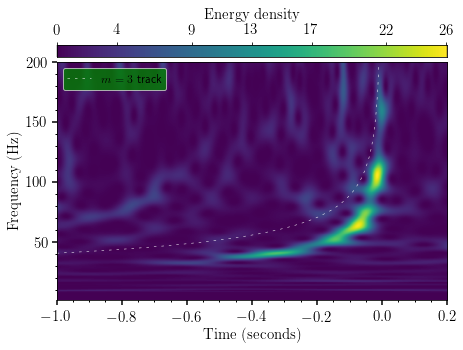

In [37]:
fig, ax = plt.subplots(figsize=(7, 4.7))

im = ax.imshow(  power , extent=[-4.0, 1.0, \
        min(freqs), max(freqs)],\
           aspect='auto', origin='lower')

ax.plot(t2-4.0, 1.5*f2, lw=0.5, dashes=(5, 10), color='w', label=r'$m=3$ track')


ax.set_ylim(1.0, 200)
ax.set_ylabel(r"\rm{Frequency (Hz)")
ax.set_xlabel(r"\rm{Time  (seconds)}")
ax.set_xlim(-1.0, 0.2)

ax.minorticks_on()
ax.tick_params(axis='both',which='minor',length=2,width=1, direction='out')
ax.tick_params(axis='both',which='major',length=5,width=1.5, direction='out')

ax2_divider = make_axes_locatable(ax)
# add an axes above the main axes.
cax2 = ax2_divider.append_axes("top", size="5%", pad="2%", label='Energy density')
cb2 = colorbar(im, cax=cax2, orientation="horizontal", \
               ticks = np.round( np.linspace(0, np.max(power), 7, endpoint=True)) )
cax2.xaxis.set_ticks_position("top")

cb2.set_label_text(r'\rm{Energy density}')
cax2.xaxis.set_label_position('top')

ax.legend(loc=2, facecolor='green')


#fig.tight_layout()
plt.savefig('tfmap_gw190412.png', bbox_inches='tight')

### Plot of $Y(\alpha)$ from on-source data

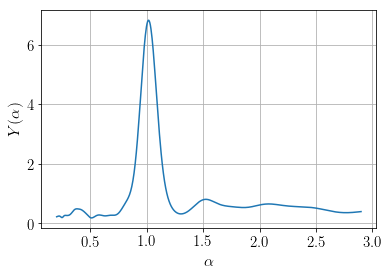

In [38]:
plt.plot( f['analysis']['alpha_arr'][:], f['analysis']['Yalpha'][:] )
plt.xlabel( r"$\alpha$", fontsize=16 )
plt.ylabel( r"$Y(\alpha)$", fontsize=16 )
plt.grid(True)

### Statistic value for the evidence of m=3 mode

In [39]:
sys.stdout.write("beta33 = %s \n" % f['analysis']['beta33'][()] )
sys.stdout.write("p-value = %s \n\n" % f['analysis']['pvalue33'][()] )

sys.stdout.write("beta44 = %s \n" % f['analysis']['beta44'][()] )
sys.stdout.write("p-value = %s \n" % f['analysis']['pvalue44'][()] )

beta33 = 6.898124382079164 
p-value = 6.593270421407642e-08 

beta44 = 1.5361978162725822 
p-value = 0.1242647967121816 


### Background distribution for m=3 mode obtained from off-source data

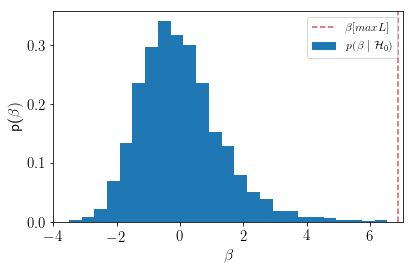

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))
_ = ax.hist(f['analysis']['beta33H0'][:], density=True, bins=25, \
            label=r"$p( \beta \mid \mathcal{H}_0 )$")
ax.axvline( x=f['analysis']['beta33'][()], linestyle='--', color='indianred', label=r'$\beta [maxL]$' )
ax.set_xlabel(r'$\beta $', fontsize=16)
ax.set_ylabel(r'p($\beta) $', fontsize=16)
ax.legend()
plt.tight_layout()

In [41]:
sys.stdout.write("beta33 = %s \n" % f['analysis']['beta33'][()] )
sys.stdout.write("Total number of off-source samples = %s \n" % len(f['analysis']['beta33H0'][:]) )
sys.stdout.write("Number of off-source samples larger than on-source = %s \n" % \
                 len( np.where( f['analysis']['beta33H0'][:] > f['analysis']['beta33'][()] )[0]) )

beta33 = 6.898124382079164 
Total number of off-source samples = 3240 
Number of off-source samples larger than on-source = 0 


### Load the entire data

In [42]:
alpha_arr = f['analysis']['alpha_arr'][:]
Salpha22 = f['analysis']['Salpha22'][:]
Salpha33 = f['analysis']['Salpha33'][:]
Salpha44 = f['analysis']['Salpha44'][:]
Yalpha = f['analysis']['Yalpha']
mualpha = f['analysis']['mualpha']

keys = f['noisebg'].keys()
Nalpha_dataFulll = f['noisebg']['nalphas'][:][:,1:,]

#idxx = np.unique(np.hstack(( np.where( np.max(Nalpha_dataFull, axis=1) >100000 )[0], \
#                                np.where( Nalpha_dataFull[:,0] >2500 )[0] )))

#Nalpha_dataFull = np.delete(Nalpha_dataFull, idxx, axis=0)
Nalpha_dataFull = Nalpha_dataFulll.copy()

times = np.delete(f['noisebg']['nalphas'][:][:,0], [], axis=0) 

midIdx = np.where(times > f['inputparams']['l1_end_time'][()] )[0][0]
deltaIdx = 1200
Nalpha_data = Nalpha_dataFull.copy()[midIdx-deltaIdx:midIdx+deltaIdx]

# Mean at each \alpha
mualpha = np.mean(Nalpha_dataFull, axis=0)
xy = np.vstack([Nalpha_data[:,j] - mualpha[j] for j in range(len(mualpha))])

# Covariance matrix
npcov = np.cov(xy)
# Inverse of covariance matrix
covinv = np.linalg.inv(npcov)


### Produce the final plot

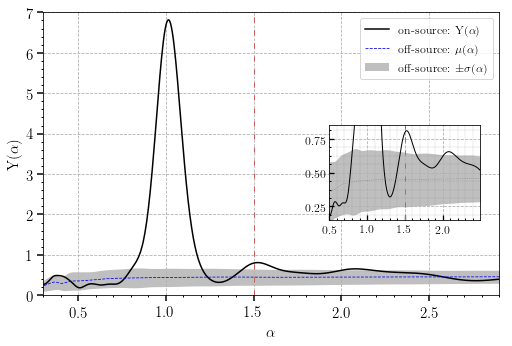

In [43]:
matplotlib.rcParams['font.size'] = 17

fig, ax = plt.subplots(figsize=(7, 4.7), constrained_layout=True)
ax.plot(alpha_arr, Yalpha, lw=1.5, c='k', label=r' \rm{on-source:} $\mathrm{Y(\alpha) }$ ')
ax.axvline(x=1.5, ls='--', c='indianred', dashes=(5, 8), lw=1.0)

ax.set_xlabel(r"$\mathrm{\alpha}$")
ax.set_ylabel(r"$\mathrm{Y(\alpha)}$")
#ax.set_title("GW190412: Asymmetric BBH event", fontsize=17)
ax.grid(linestyle='dashed')

ax.plot(alpha_arr, mualpha, color='b', lw=0.8, ls='--', label=r' \rm{off-source:}  $\mathrm{\mu(\alpha)}$')
ax.fill_between(alpha_arr, mualpha, mualpha+np.diagonal(npcov)**0.5, color='gray', edgecolor="b", linewidth=0.0, \
                alpha=0.5, label=r'\rm{off-source:} $\mathrm{\pm \sigma(\alpha) }$')
ax.fill_between(alpha_arr, mualpha, mualpha-np.diagonal(npcov)**0.5, \
                edgecolor="b", linewidth=0.0, color='gray', alpha=0.5)
ax.set_xlim(0.3, 2.9)
ax.set_yticks( np.arange(0, 8) )
ax.set_ylim(0.0, 7.0)

ax.minorticks_on()

ax.tick_params(axis='both',which='minor',length=2,width=1, direction='out')
ax.tick_params(axis='both',which='major',length=6,width=1.5, direction='out')


sub_axes = plt.axes([.645, .36, .3, .28]) 
# plot the zoomed portion
sub_axes.plot(alpha_arr, Yalpha, lw=1., c = 'k') 
sub_axes.set_ylim(0.15, 0.85)
sub_axes.set_xlim(0.5, 2.5)
sub_axes.ticklabel_format(style='plain', axis='y', scilimits=(0,0), labelsize=12)

sub_axes.axvline(x=1.5, ls='--', c='indianred', dashes=(5, 8), lw=1.0)

sub_axes.tick_params(axis='both',which='minor',length=2,width=1, direction='in', labelsize=12)
sub_axes.tick_params(axis='both',which='major',length=5,width=1.3, direction='in', labelsize=12)
sub_axes.set_xticks([0.5, 1.0, 1.5, 2.0])


sub_axes.plot(alpha_arr, mualpha, color='gray', lw=0.7, ls=':', label=r' off source: $\mathrm{\mu(\alpha) }$')
sub_axes.fill_between(alpha_arr, mualpha, mualpha+np.diagonal(npcov)**0.5, color='gray', alpha=0.5, \
                edgecolor="b", linewidth=0.0, label=r'off-source: $\pm \sigma(\alpha)$')
sub_axes.fill_between(alpha_arr, mualpha, mualpha-np.diagonal(npcov)**0.5, color='gray', \
                      edgecolor="b", linewidth=0.0, alpha=0.5)




sub_axes.minorticks_on()
sub_axes.grid(linestyle='dashed')
sub_axes.grid(b=True, which='minor', color='gray', linestyle='--', lw=0.2)

#ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax.legend(loc=1)
#fig.tight_layout()

plt.savefig("Yalpha_gw190412.png")

In [44]:
sys.stdout.write("mass1: %s \n"  % f['inputparams']['mass1'][()] )
sys.stdout.write("mass2: %s \n"  % f['inputparams']['mass2'][()] )
sys.stdout.write("spin1z: %s \n" % f['inputparams']['spin1z'][()] )
sys.stdout.write("spin1z: %s \n" % f['inputparams']['spin2z'][()] )
sys.stdout.write("geocentric time: %s \n" % f['inputparams']['t0'][()] )
sys.stdout.write("detector time: %s \n" % f['inputparams']['l1_end_time'][()] )


mass1: 33.76798828818286 
mass2: 9.700004180482646 
spin1z: 0.28558620162670567 
spin1z: 0.03826741661275385 
geocentric time: 1239082262.181084 
detector time: 1239082262.1614943 
